# News Summarization Approaches for NLP

Text summarization in NLP is the process of summarizing the information in large texts for quicker consumption. In this notebook, I will walk you through the traditional extractive as well as the advanced generative methods to implement News summarization.

When you open news sites, do you just start reading every news article? Probably not. We typically glance the short news summary and then read more details if interested. Short, informative summaries of the news is now everywhere like magazines, news aggregator apps, research sites, etc.
It is essential for the summary to be a fluent, continuous and depict the significant.

Text summarization methods can be grouped into two main categories: 
- Extractive 
- Abstractive 





In [10]:
#import necessary libraries
## for uploadinf data
import pandas as pd
import os
from pathlib import Path


## for uploadinf data
import pandas as pd
import os
import numpy as np


## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## import necessary nlp libraries
import re
import nltk
from nltk import download
download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
from nltk import sent_tokenize


from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

# TextRank 
from sumy.summarizers.text_rank import TextRankSummarizer

# LexRank
from sumy.summarizers.lex_rank import LexRankSummarizer

#BART 
from transformers import BartTokenizer, BartForConditionalGeneration
import torch
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

# Evaluation
from sumy.evaluation.rouge import rouge_1,rouge_2
from rouge import Rouge
rouge = Rouge()
from rouge.rouge_score import rouge_n,rouge_l_summary_level


[nltk_data] Downloading package stopwords to /home/mo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Contractions

In [5]:

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions_dict =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}


### CURRENCIES and EMAILS

In [6]:

CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR",}
CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE,)



## Helper Function


In [23]:
def LoadingArticles(filepath):
    """ Loading Articles from folders in returned back as dataframe """
    
    def extract(filepath):
        """ Extract text from files """
        pattern = r'(\w+)/(\d+)\.txt$'
        category, file_id = re.search(pattern, str(filepath)).groups()
        with open(filepath, 'r', encoding='unicode_escape') as f:
            text = f.read()

            return category, file_id, text
    articles_data = list(map(extract, filepath.glob('News Articles/*/*.txt')))
    summaries_data = list(map(extract, filepath.glob('Summaries/*/*.txt')))
    
    articles_df = pd.DataFrame(articles_data, columns=('Category', 'ID', 'Article'))
    articles_df['Article']=articles_df['Article'].str.replace("\n\n"," , ")
    summaries_df = pd.DataFrame(summaries_data, columns=('Category', 'ID', 'Summary'))
    df = articles_df.merge(summaries_df, how='inner', on=('Category', 'ID'))

    
    return df
    
    
## got this function from https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def expand_contractions(s, contractions_dict=contractions_dict):
    """ Expand Contractions """
    def replace(match):
        return contractions_dict[match.group(0)]
    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

    return contractions_re.sub(replace, s)




def normalize_Text(row, remove_stopwords = True):
    row=row.lower()  #make text in lower cases

    row=expand_contractions(row) #handeling the Contractions
    row = EMAIL_REGEX.sub(' ',str(row)) #remove any email
    row = CURRENCY_REGEX.sub(' ',str(row)) #currency handling
    row= re.sub("(@[A-Za-z0-9]+)",' ',str(row)) #remove any hashtages
    row= re.sub("(#[A-Za-z0-9]+)",' ',str(row)) #remove any mentions
    row=re.sub(r'http\S+', '', str(row)) #remove any url
    
    # separate with no blundry MachineLeaning -> Machine Learning 
    row =' '.join(re.findall('[A-Za-z]*[^A-Z]*',  str(row))) 
    row =' '.join(re.findall('[(A-Z)-a-z]*[^A-Z]*',  str(row)))
    row=" ".join(nltk.word_tokenize(row))
    row = re.sub(r'[.\s][[A-Za-z0-9]*\.(com|org|edu|gif,net)','', str(row)) # remove any wibsite link
    row = re.sub(r'(--)+', ' ', str(row)) #remove any (--)or more come togethe
    row = re.sub(r'((P|p)([.])(M|m))|((A|a)([.])(M|m))', lambda x: x.group().replace(".", ""), str(row)) #P.M -> PM 
    row = re.sub(r'\s:\s',' ', str(row))
    # 3 cases to separate by (-) -> (word-digit)(word-word)(digit-word)
    row =re.sub(r'(\d*[-]\w*)|(\w*[-]\w*)|(\w*[-]\d*)', lambda x: x.group().replace("-", " "), str(row)) 
    row = re.sub(r'((\w+)([.])(\w+))', lambda x: x.group().replace(".", ""), str(row)) #take.note -> take note
    row =re.sub(r'([.])(\w+)', lambda x: x.group().replace(".", " . "),str(row)) # .first -> first
    row =re.sub(r'(\w+)([.])', lambda x: x.group().replace(".", " . "),str(row))
    
    row=nltk.sent_tokenize(row)
    row=" ".join([lem.lemmatize(word) for word in row if word not in stopwords.words('english')])
    row=re.sub(r"""[<>——_―()|&=\‘”"“``\'\♥️🇺🇸'+\"©ø/\[\]\\;?~*!]""", ' ', str(row)) 
    row=re.sub(r'(\s[’]\s)', lambda x: x.group().replace(" ’ ", "’"), str(row)) #the countery's Leader  -> c ' d
    row = re.sub(' +', ' ', str(row)) #remove multi spaces or tap

    #row=row[:row.find('sign up')
    #row=row[:row.find('download')]
    
#     if remove_stopwords: # remove stop words
#         text = row.split()
#         stops = set(stopwords.words("english"))
#         row = [w for w in text if not w in stops]
#         row = " ".join(row)
    return row

def make_summarizer(summarizer_cls, language='english', sentences_count=3):
    def _summarizer(text):
            sentences=" ".join(sent_tokenize(text))
            #Initializing the parser
            parser = PlaintextParser.from_string(sentences, Tokenizer(language))
            # Creating a summary of 2 sentences
            summarizer=summarizer_cls(parser.document, sentences_count)
            summary = []
            for sentence in summarizer:
                summary.append(str(sentence))
            return ''.join(summary)

            

    return _summarizer


## Get the Data


In [9]:
DATA_PATH=Path("./dataset/BBC/BBC News Summary/")
newsDF=LoadingArticles(DATA_PATH)

newsDF.head()

,Category,ID,Article,Summary
0,business,424,"EU-US seeking deal on air dispute , The EU and...",Both sides hope to reach a negotiated deal ove...
1,business,441,"Trade gap narrows as exports rise , The UK's t...",Overall UK exports - including both goods and ...
2,business,214,"Economy 'strong' in election year , UK busines...",The BDO optimism index - a leading indicator o...
3,business,305,"Brazil approves bankruptcy reform , A major re...","The new legislation changes this, giving prior..."
4,business,174,"Yangtze Electric's profits double , Yangtze El...","Yangtze Electric Power, the operator of China'..."


# Clean the Data

Removing unnecessary text. For Example:
- CURRENCIES
- EMAILS
- CONTRACTIONS

        Contraction: changing short word to long. For Example: “ain’t” = “is not”; “can’t” = “cannot”.
        
Then cleaning and normilzing the text

In [43]:
newsDF["Cleaned_Article"] =newsDF['Article'].apply(lambda x:normalize_Text(x)) 
newsDF["Cleaned_Summary"] =newsDF['Summary'].apply(lambda x:normalize_Text(x)) 


In [44]:
newsDF.head()

,Category,ID,Article,Summary,Cleaned_Article,Cleaned_Summary
0,business,424,"EU-US seeking deal on air dispute , The EU and...",Both sides hope to reach a negotiated deal ove...,"eu us seeking deal on air dispute , the eu and...",both sides hope to reach a negotiated deal ove...
1,business,441,"Trade gap narrows as exports rise , The UK's t...",Overall UK exports - including both goods and ...,"trade gap narrows as exports rise , the uk s t...",overall uk exports including both goods and se...
2,business,214,"Economy 'strong' in election year , UK busines...",The BDO optimism index - a leading indicator o...,"economy strong in election year , uk businesse...",the bdo optimism index a leading indicator of ...
3,business,305,"Brazil approves bankruptcy reform , A major re...","The new legislation changes this, giving prior...","brazil approves bankruptcy reform , a major re...","the new legislation changes this , giving prio..."
4,business,174,"Yangtze Electric's profits double , Yangtze El...","Yangtze Electric Power, the operator of China'...","yangtze electric s profits double , yangtze el...","yangtze electric power , the operator of china..."


# Plotting Words Distribution

#### Article

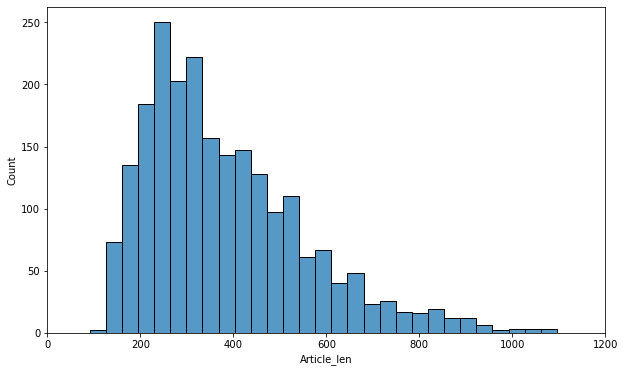

In [125]:
articles = newsDF['Article'].to_list()
newsDF['Article_len'] = newsDF['Article'].apply(lambda x: len(re.findall("\w+",x)))
plt.figure(figsize=(10,6))
plt.xlim([0,1200]) 
sns.histplot(data=newsDF, x='Article_len')
plt.show()

#### Summary

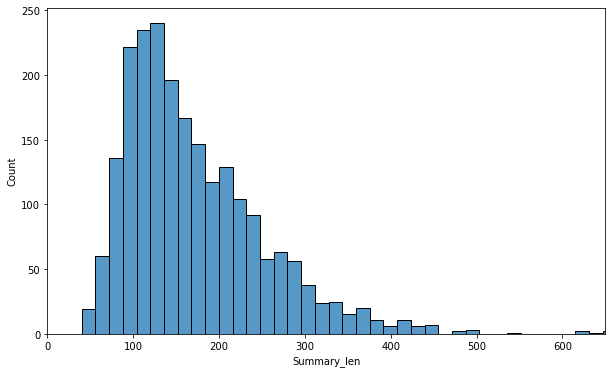

In [127]:
articles = newsDF['Summary'].to_list()
newsDF['Summary_len'] = newsDF['Summary'].apply(lambda x: len(re.findall("\w+",x)))
plt.figure(figsize=(10,6))
plt.xlim([0,650]) 
sns.histplot(data=newsDF, x='Summary_len')
plt.show()

# Extractive Text Summarization

 It is the traditional method developed first. The main objective is to identify the significant sentences of the text and add them to the summary. You need to note that the summary obtained contains exact sentences from the original text.

In this section we will discuss two extractive methods:
 - TextRank 
 - LexRank

## TextRank

TextRank is an extractive summarization technique. It is based on the concept that words which occur more frequently are significant. Hence , the sentences containing highly frequent words are important.

Based on this , the algorithm assigns scores to each sentence in the text . The top-ranked sentences make it to the summary.

After importing the sumy package, the first step is to import TextRankSummarizer from sumy.summarizers.text_rank. It is an in-built model that implements TextRank.

Next, pass the text corpus as input to summarize function

We can decide the number of sentences you want in the summary through parameter sentences_count.
We can change the default parameters of the summarize function according to your requirements.

In [45]:
#Applying TextRank summarization on data
newsDF['Summary (TextRank)'] = newsDF["Cleaned_Article"].apply(make_summarizer(TextRankSummarizer()))


In [24]:
TEXT="""extRank is an extractive summarization technique. It is based on the concept that words which occur more frequently are significant. Hence , the sentences containing highly frequent words are important.

Based on this , the algorithm assigns scores to each sentence in the text . The top-ranked sentences make it to the summary.

After importing the sumy package, the first step is to import TextRankSummarizer from sumy.summarizers.text_rank. It is an in-built model that implements TextRank.

Next, pass the text corpus as input to summarize function

We can decide the number of sentences you want in the summary through parameter sentences_count. We can change the default parameters of the summarize function according to your requirements
"""

make_summarizer(TEXT,"extractive",TextRankSummarizer())

NameError: name 'summary' is not defined

In [83]:
rouge.get_scores(newsDF['Summary (TextRank)'],newsDF['Cleaned_Summary'],avg=True)

{'rouge-1': {'r': 0.4571161227507897,
  'p': 0.6876894556027271,
  'f': 0.536492978845241},
 'rouge-2': {'r': 0.3477464353555783,
  'p': 0.5522263750828629,
  'f': 0.41332502474854066},
 'rouge-l': {'r': 0.43390923067900067,
  'p': 0.652367358034751,
  'f': 0.5092454549790129}}

let's look at our TestRank Rouge-n score distribution

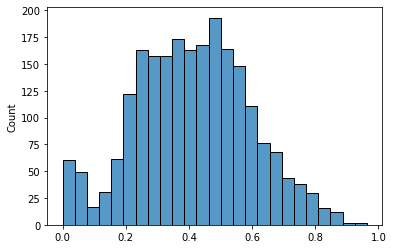

In [82]:
#Plot our TestRank Rouge-n score distribution 
TextRankSummaryrougeF1Score=[]
for i in range(0,len(newsDF['Summary (TextRank)'].values)):
    TextRankSummaryrougeF1Score.append(rouge.get_scores(newsDF['Summary (TextRank)'].values[i],newsDF['Cleaned_Summary'].values[i],avg=True)['rouge-2']['f'])
    
sns.histplot(TextRankSummaryrougeF1Score);

In [49]:
newsDF.to_pickle('./dataset/TextRankSummaryBBC.p')
newsDF=pd.read_pickle("./dataset/TextRankSummaryBBC.p")


Similar to TextRank , there is LexRank algorithm which perform summarization.

## LexRank

Along with TextRank , sumy has various other algorithms to summarize text.
In this section, I shall discuss on implementation of the LexRank algorithm for summarization using sumy.

A sentence which is similar to many other sentences of the text has a high probability of being important. The approach of LexRank is that a particular sentence is recommended by other similar sentences and hence is ranked higher.Higher the rank, higher is the priority of being included in the summarized text.


We import PlaintextParser since we have a article stored as a string hence we use it Along with parser, you have to import Tokenizer for segmenting the raw text into tokens.

As the text source here is a string, you need to use PlainTextParser.from_string() function to initialize the parser. You can specify the language used as input to the Tokenizer.

In [52]:
#Applying LexRank on data
newsDF['Summary (LexRank)'] = newsDF["Cleaned_Article"].apply(make_summarizer(LexRankSummarizer() ))

In [84]:
rouge.get_scores(newsDF['Summary (LexRank)'],newsDF['Cleaned_Summary'], avg=True)

{'rouge-1': {'r': 0.4415985610078952,
  'p': 0.7739808283765983,
  'f': 0.5480845836331633},
 'rouge-2': {'r': 0.3280878216556022,
  'p': 0.6371476737319538,
  'f': 0.4182057589608476},
 'rouge-l': {'r': 0.4244969923128706,
  'p': 0.7431776733449098,
  'f': 0.5267217595616718}}

let's look at our LexRank Rouge-n score distribution

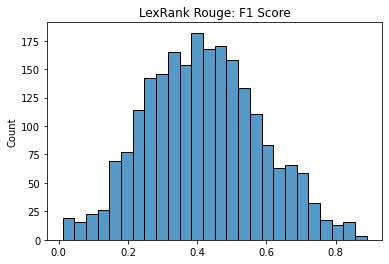

In [87]:
#plot our LexRank Rouge-n score distribution
LexRankSummaryrougeF1Score=[]
for i in range(0,len(newsDF['Summary (LexRank)'].values)):
    LexRankSummaryrougeF1Score.append(rouge.get_scores(newsDF['Summary (LexRank)'].values[i],newsDF['Cleaned_Summary'].values[i],avg=True)['rouge-2']['f'])
plt.title("LexRank Rouge: F1 Score")
sns.histplot(LexRankSummaryrougeF1Score);


In [55]:
newsDF.to_pickle('./dataset/LexRankSummaryBBC.p')
newsDF=pd.read_pickle("./dataset/LexRankSummaryBBC.p")

### It's time to compare TextRank with LexRank based on their Rouge score.

In [88]:
text_rank_scores = rouge.get_scores(newsDF['Summary (TextRank)'],newsDF['Cleaned_Summary'], avg=True)
lex_rank_scores = rouge.get_scores(newsDF['Summary (LexRank)'],newsDF['Cleaned_Summary'], avg=True)

text_rank_scores_df = pd.DataFrame(text_rank_scores)
lex_rank_scores_df = pd.DataFrame(lex_rank_scores)

scores_df = text_rank_scores_df.join(lex_rank_scores_df, lsuffix=' (TextRank)', rsuffix=' (LexRank)').sort_index(axis=1)
scores_df

,rouge-1 (LexRank),rouge-1 (TextRank),rouge-2 (LexRank),rouge-2 (TextRank),rouge-l (LexRank),rouge-l (TextRank)
r,0.441599,0.457116,0.328088,0.347746,0.424497,0.433909
p,0.773981,0.687689,0.637148,0.552226,0.743178,0.652367
f,0.548085,0.536493,0.418206,0.413325,0.526722,0.509245


# Abstractive Text Summarization

Abstractive summarization is the new state of art method, which generates new sentences that could best represent the whole text. This is better than extractive methods where sentences are just selected from original text for the summary.

Some common abstractive models are :
- GPT-2
- GPT-3
- BERT 
- OpenAI
- GPT
- T5
- BART

An awesome feature with transformers is that it provides PreTrained models with weights that can be easily instantiated through from_pretrained() method.
In this section we will discuss on BART transformer implementation. 


##  BART Transformer

BART is an encoder-decoder model. It converts all language problems into a text-to-text format.

In [ ]:
## install packages 
# !pip install pytorch_lightning 
# !pip install nlp
# !pip install transformers
# !pip install sentencepiece
# !pip install --upgrade pip
# !pip install transformers[sentencepiece]


In [89]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

In [90]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

In [91]:
BartsummaryDict={}


In [92]:
i=0

for text in newsDF['Cleaned_Article'].values:
    inputs = tokenizer([text], padding=True, truncation=True, max_length=512,return_tensors="pt") # change max_length for shorter summaries
    outputs = model.generate(inputs['input_ids'], num_beams=4, max_length=80, early_stopping=True)
    BartsummaryDict[text] = " ".join([tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=False) for output in outputs])

    i+=1
    if i % 250 == 0:
        print(i)


/home/mo/anaconda3/lib/python3.7/site-packages/transformers/generation_utils.py:1648: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size
/home/mo/anaconda3/lib/python3.7/site-packages/transformers/generation_utils.py:1648: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // v

250
500
750
1000
1250
1500
1750
2000


In [101]:
Bartsummary=pd.DataFrame(BartsummaryDict.items(),columns=['Cleaned_Article','BARTSummary'])

In [103]:
newsDF=newsDF.merge(Bartsummary,on='Cleaned_Article')

In [111]:
rouge.get_scores(newsDF['BARTSummary'],newsDF['Cleaned_Summary'], avg=True)


{'rouge-1': {'r': 0.32356351899703745,
  'p': 0.666021931748919,
  'f': 0.4242069561327858},
 'rouge-2': {'r': 0.19837291122056996,
  'p': 0.49424858965950613,
  'f': 0.27340107743714703},
 'rouge-l': {'r': 0.3067344187052067,
  'p': 0.631495122848379,
  'f': 0.40221136751975445}}

let's look at our LexRank Rouge-n score distribution

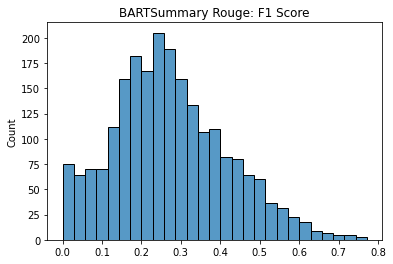

In [112]:
#plot our LexRank Rouge-n score distribution
BARTSummaryrougeF1Score=[]
for i in range(0,len(newsDF['Summary (LexRank)'].values)):
    BARTSummaryrougeF1Score.append(rouge.get_scores(newsDF['BARTSummary'].values[i],newsDF['Cleaned_Summary'].values[i],avg=True)['rouge-2']['f'])
plt.title("BARTSummary Rouge: F1 Score")
sns.histplot(BARTSummaryrougeF1Score);


In [121]:
text_rank_scores = rouge.get_scores(newsDF['Summary (TextRank)'],newsDF['Cleaned_Summary'], avg=True)
lex_rank_scores = rouge.get_scores(newsDF['Summary (LexRank)'],newsDF['Cleaned_Summary'], avg=True)
bart_scores = rouge.get_scores(newsDF['BARTSummary'],newsDF['Cleaned_Summary'], avg=True)

text_rank_scores_df = pd.DataFrame(text_rank_scores)
lex_rank_scores_df = pd.DataFrame(lex_rank_scores)
bart_scores_df = pd.DataFrame(bart_scores)
text_rank_scores_df.columns=text_rank_scores_df.columns+"(Text Rank)"
lex_rank_scores_df.columns=lex_rank_scores_df.columns+"(Lex Rank)"
bart_scores_df.columns=bart_scores_df.columns+"(BART)"


### It's time to compare  all the models based on their Rouge score.

In [122]:
pd.concat([text_rank_scores_df,lex_rank_scores_df,bart_scores_df],axis=1)

,rouge-1(Text Rank),rouge-2(Text Rank),rouge-l(Text Rank),rouge-1(Lex Rank),rouge-2(Lex Rank),rouge-l(Lex Rank),rouge-1(BART),rouge-2(BART),rouge-l(BART)
r,0.457116,0.347746,0.433909,0.441599,0.328088,0.424497,0.323564,0.198373,0.306734
p,0.687689,0.552226,0.652367,0.773981,0.637148,0.743178,0.666022,0.494249,0.631495
f,0.536493,0.413325,0.509245,0.548085,0.418206,0.526722,0.424207,0.273401,0.402211


In [123]:
newsDF.to_pickle('./dataset/BARTSummaryBBC.p')
newsDF=pd.read_pickle("./dataset/BARTSummaryBBC.p")